In [1]:
from preprocess import dataset,get_Kfold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from models import FM_MLP,AE_MLP,get_models
from torch import optim
from torch.utils.data import DataLoader,Dataset
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import json
import random
from TrainandTest import train_MLP,test_MLP
import pandas as pd

def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(1)

# Config

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
file = './data/jiji small126.xlsx'
para_path = './save/parameter'
batch_size = 300
plot = True
scaler = StandardScaler()

# Train

-----------[ K:1 Type:odd N_size:<126 ]-----------
loss:0.055215686559677124 saving...
Test Loss: 0.07196, Test RMSE: 0.26825


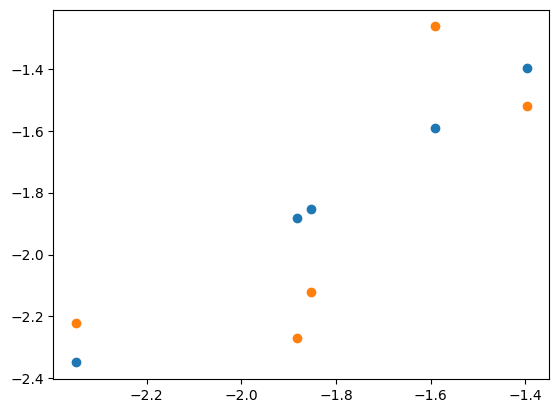

-----------[ K:2 Type:odd N_size:<126 ]-----------
loss:0.06060846894979477 saving...
Test Loss: 0.17340, Test RMSE: 0.41642


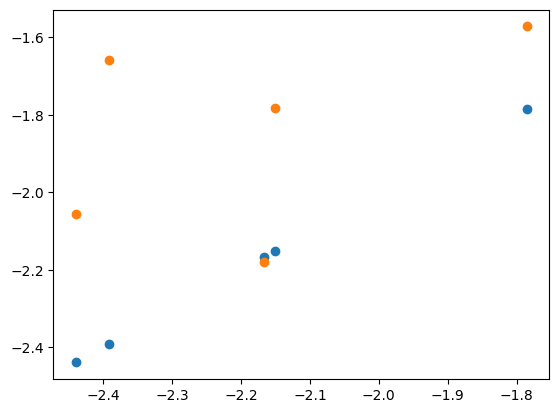

-----------[ K:3 Type:odd N_size:<126 ]-----------
loss:0.061964526772499084 saving...
Test Loss: 0.03178, Test RMSE: 0.17826


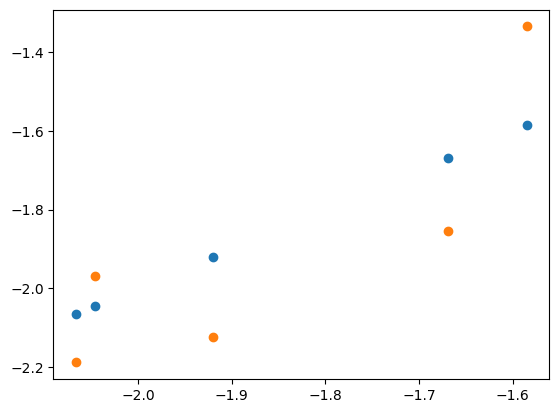

-----------[ K:4 Type:odd N_size:<126 ]-----------
loss:0.04971383884549141 saving...
Test Loss: 0.18627, Test RMSE: 0.43159


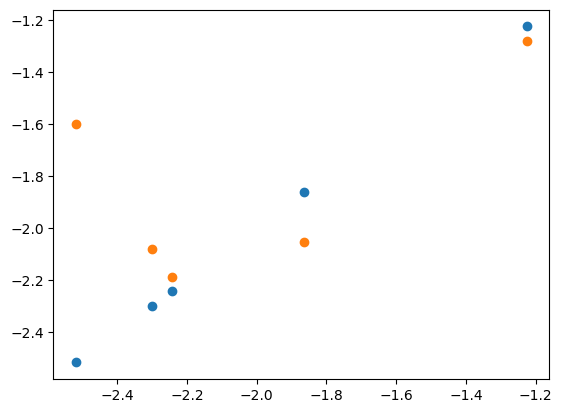

-----------[ K:5 Type:odd N_size:<126 ]-----------
loss:0.05451060086488724 saving...
Test Loss: 0.07103, Test RMSE: 0.26652


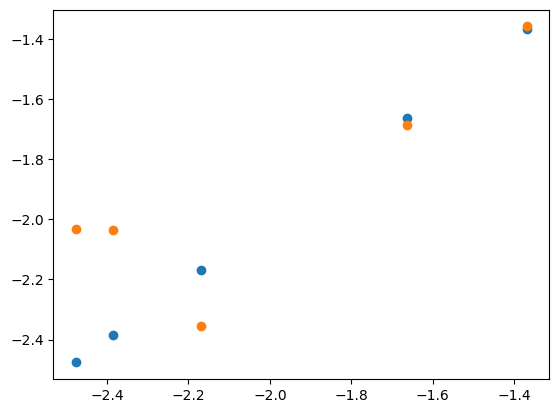

-----------[ K:6 Type:odd N_size:<126 ]-----------
loss:0.05600130185484886 saving...
Test Loss: 0.10212, Test RMSE: 0.31956


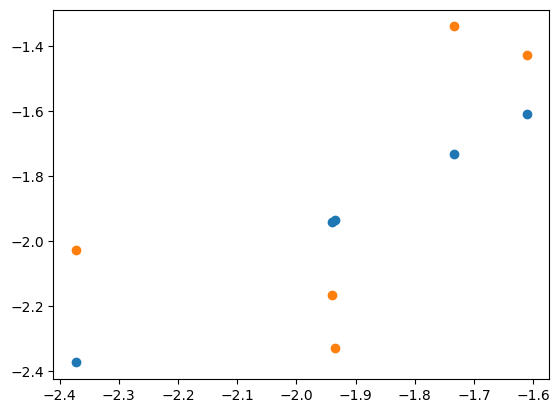

-----------[ K:7 Type:odd N_size:<126 ]-----------
loss:0.04795236513018608 saving...
Test Loss: 0.12311, Test RMSE: 0.35087


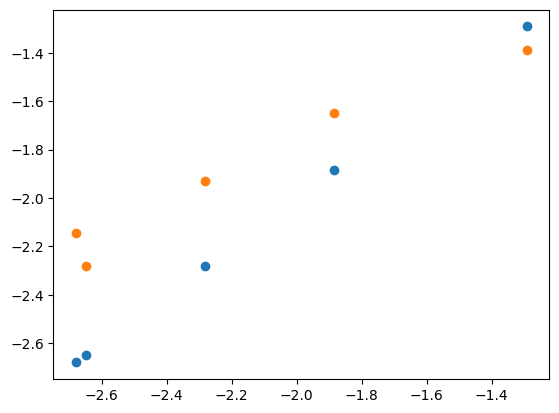

-----------[ K:8 Type:odd N_size:<126 ]-----------
loss:0.06192804127931595 saving...
Test Loss: 0.05964, Test RMSE: 0.24421


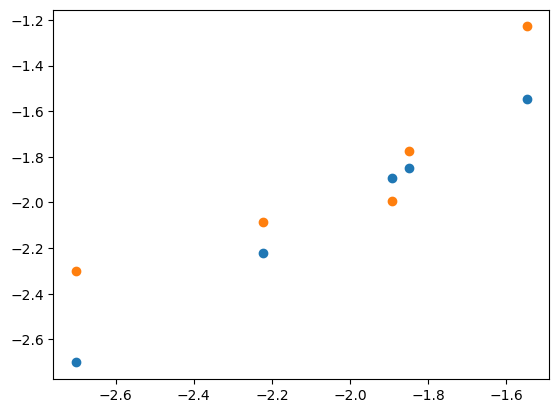

-----------[ K:9 Type:odd N_size:<126 ]-----------
loss:0.06121153384447098 saving...
Test Loss: 0.12764, Test RMSE: 0.35727


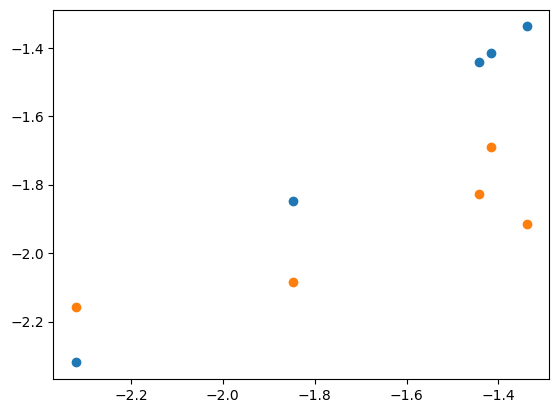

-----------[ K:10 Type:odd N_size:<126 ]-----------
loss:0.05998885631561279 saving...
Test Loss: 0.42810, Test RMSE: 0.65430


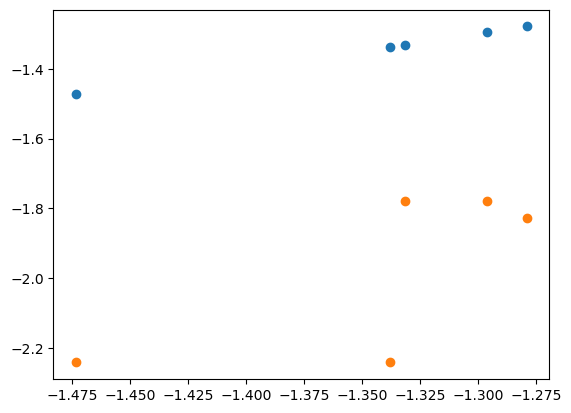

total rmse of k fold is: 1.7436255542408041
-----------[ K:1 Type:odd N_size:<126 ]-----------
loss:0.18223769962787628 saving...
Test Loss: 0.64929, Test RMSE: 0.83826


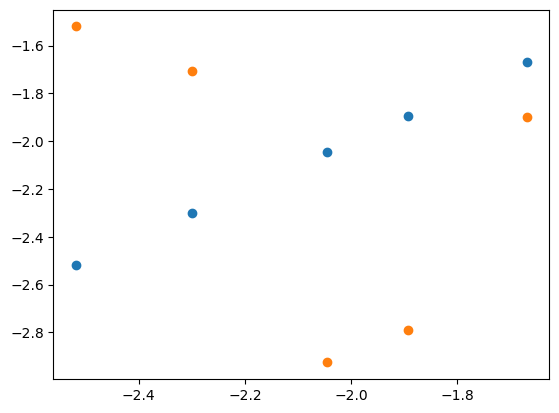

-----------[ K:2 Type:odd N_size:<126 ]-----------
loss:0.03382127732038498 saving...
Test Loss: 0.43832, Test RMSE: 0.69099


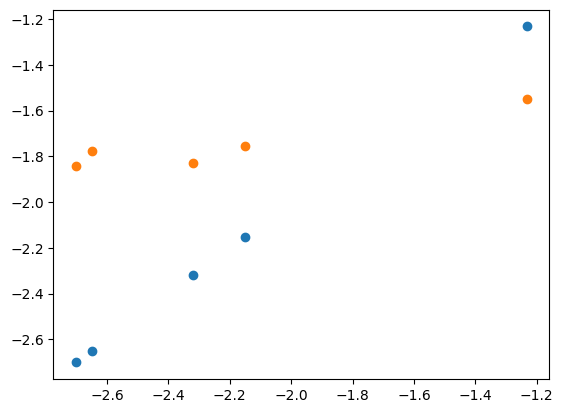

-----------[ K:3 Type:odd N_size:<126 ]-----------
loss:0.04272877424955368 saving...
Test Loss: 0.39627, Test RMSE: 0.82089


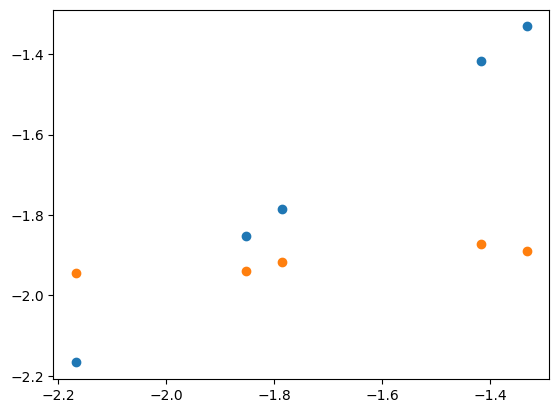

-----------[ K:4 Type:odd N_size:<126 ]-----------
loss:0.047844298183918 saving...
Test Loss: 0.72737, Test RMSE: 1.19214


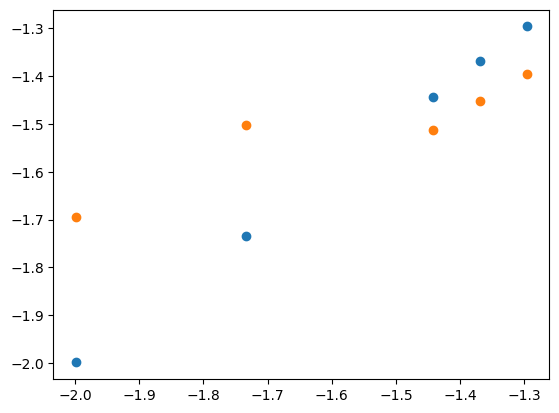

-----------[ K:5 Type:odd N_size:<126 ]-----------
loss:0.12312637269496918 saving...
Test Loss: 0.58269, Test RMSE: 0.93961


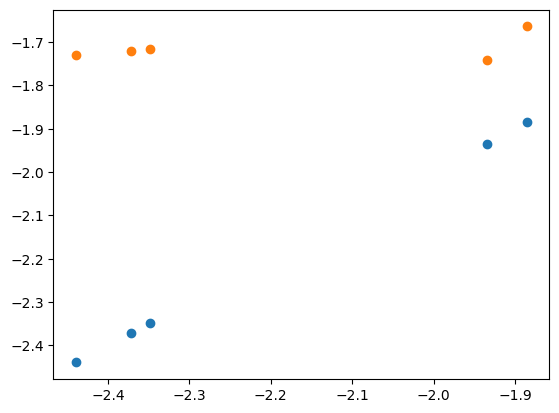

-----------[ K:6 Type:odd N_size:<126 ]-----------
loss:0.11529809236526489 saving...
Test Loss: 0.61856, Test RMSE: 0.81471


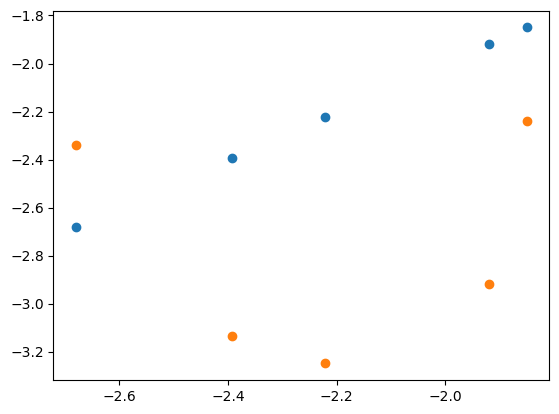

-----------[ K:7 Type:odd N_size:<126 ]-----------
loss:0.06775874644517899 saving...
Test Loss: 0.34331, Test RMSE: 0.78453


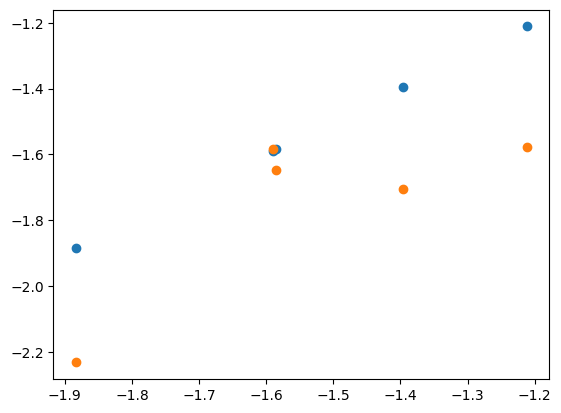

-----------[ K:8 Type:odd N_size:<126 ]-----------
loss:0.08133335411548615 saving...
Test Loss: 0.25371, Test RMSE: 0.51241


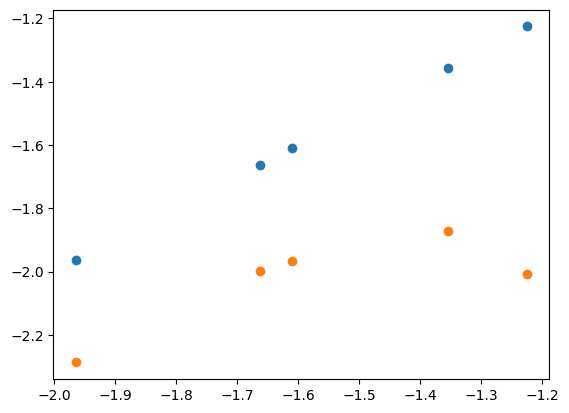

-----------[ K:9 Type:odd N_size:<126 ]-----------
loss:0.044144898653030396 saving...
Test Loss: 0.65700, Test RMSE: 1.08650


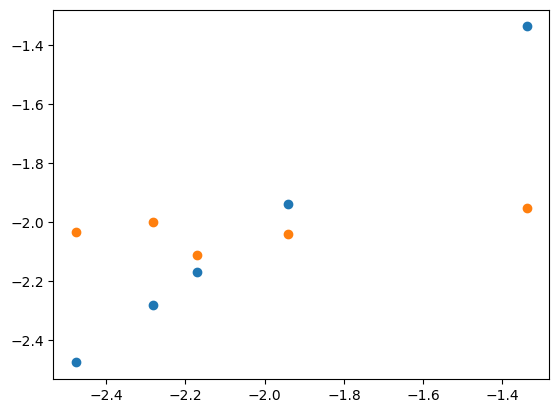

-----------[ K:10 Type:odd N_size:<126 ]-----------
loss:0.18088150024414062 saving...
Test Loss: 0.45133, Test RMSE: 0.74234


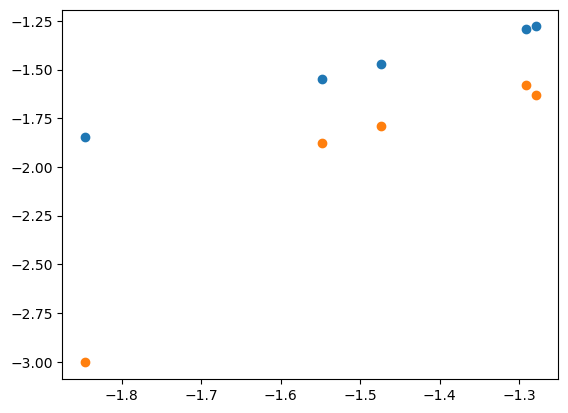

total rmse of k fold is: 4.211188552896625


In [3]:
with open('config.json','r',encoding='utf-8')as f:
    config_list = json.load(f)

for config in config_list:
    Type = config['Type']
    N_size = config['N_size']
    num_epoch = config['num_epoch']
    lr = config['lr']
    decay = config["decay"]
    k = config['k']
    alpha = config['alpha']
    input_size = config['input_size']
    L1,L2 = config['L1'],config['L2']
    
    K_fold_data = get_Kfold(file,k)
    rmse_list = []
    
    for k_step,(trian_data,test_data) in enumerate(K_fold_data):
        tqdm.write(f"-----------[ K:{k_step+1} Type:{Type} N_size:{N_size} ]-----------")
        
        model = get_models(config['model'],input_size,L1,L2).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=decay)
        lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,lambda x: 1 - x/num_epoch,last_epoch=-1)
        
        #get data prepared
        trian_data = dataset(trian_data,Type,N_size,input_size,scaler)
        test_data = dataset(test_data,Type,N_size,input_size,scaler)
        train_loader = DataLoader(dataset=trian_data,batch_size=batch_size)
        test_loader = DataLoader(dataset=test_data,batch_size=batch_size)
        
        #train
        train_MLP(train_loader,
                  model,
                  criterion,
                  alpha,
                  optimizer,
                  num_epoch,
                  k_step,
                  lr_scheduler,
                  para_path,
                  device)
        
        #tese
        total_mse = test_MLP(test_loader,
                             model,
                             k_step,
                             criterion,
                             alpha,
                             plot,
                             para_path,
                             device)
        rmse_list.append(total_mse*len(K_fold_data[k_step-1][1]))
        

    tqdm.write(f"total rmse of k fold is: {(sum(rmse_list)/len(rmse_list))}")